In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install transformers

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
import re
import pandas as pd

In [4]:
data_combined = pd.read_csv("/content/combined_data.csv", encoding='Windows-1252', sep = ';', error_bad_lines=False)
data_combined['label'] = data_combined['label'].fillna(0)
data_combined['label'] = data_combined['label'].astype(int)
data_combined

<ipython-input-4-63a4ce08c339>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data_combined = pd.read_csv("/content/combined_data.csv", encoding='Windows-1252', sep = ';', error_bad_lines=False)


,text,label
0,binus! woi yang parkir pararel jangan di rem ...,0
1,binus! bantu plis,0
2,binus! yang dari bekasi region mana ajah mutu...,2
3,struggle! lagi kelas lab si laptop malah blue...,0
4,Binus! Briefing tentang Sertifikasi Non Credi...,1
...,...,...
1828,uts itu per harinya 1 matkul kah? binus!,1
1829,binus! serius aku jg lgd diperiksa sama vice ...,2
1830,dia friendly banget tapi kenapa sama aku jude...,0
1831,"binus! kayanya gua kecantol beda agama deh, b...",0


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = data_combined['text'].apply(lambda x: tokenizer.encode_plus(
                                  x,
                                  add_special_tokens=True,
                                  max_length=250,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt'))

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
text_len = data_combined['text'].apply(lambda x: len(str(x).split()))
text_len.max()

239

In [7]:
tokens[0]
# input_ids -> 101[CLS], 102[SEP]
# input_type_ids -> 0 means 1 sentence, if there is 1 = 2 sentence
# attention_mask => 1 real token, 0 padding

{'input_ids': tensor([[  101,  8026,  2271,   999, 24185,  2072,  8675,  2380,  4313, 11498,
         16570, 23769,  2319,  4487,  2128,  2213,  9745,  2319,  2938,  1010,
         12306,  2243, 11320, 27829, 14289, 13807,  2078, 20904,  4430, 19982,
          2139,  9739,  6336,  1043,  2860, 17710,  7630,  2906, 10514,  3736,
          2232, 28490,  4017,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [25]:
print(data_combined.iloc[2, 0])

 binus! yang dari bekasi region mana ajah mutualan yu


In [9]:
input_ids = torch.stack([item['input_ids'][0] for item in tokens])
attention_masks = torch.stack([item['attention_mask'][0] for item in tokens])
labels = torch.tensor(data_combined['label'].values)

In [10]:
dataset = TensorDataset(input_ids, attention_masks, labels)

In [11]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

loss_function = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(train_loader):
        batch_input_ids, batch_attention_mask, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 | Train Loss: 1.0104488412971082
Epoch 2 | Train Loss: 0.8964668292066326
Epoch 3 | Train Loss: 0.8179305429043977


In [ ]:
torch.save(model, '/content/bert_model.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded = model = torch.load('/content/bert_model.pth')
model_loaded.to(device)
model_loaded.eval()

all_predictions, all_true_labels = [], []

for batch in val_loader:
    batch_input_ids, batch_attention_mask, batch_labels = [b.to(device) for b in batch]

    with torch.no_grad():
        outputs = model_loaded(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()
    labels = batch_labels.cpu().numpy()

    all_predictions.extend(predictions)
    all_true_labels.extend(labels)


In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy = accuracy_score(all_true_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='weighted')
print(f'Validation Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Validation Accuracy: 0.6485013623978202
Precision: 0.646173649599107
Recall: 0.6485013623978202
F1 Score: 0.6259769267643772


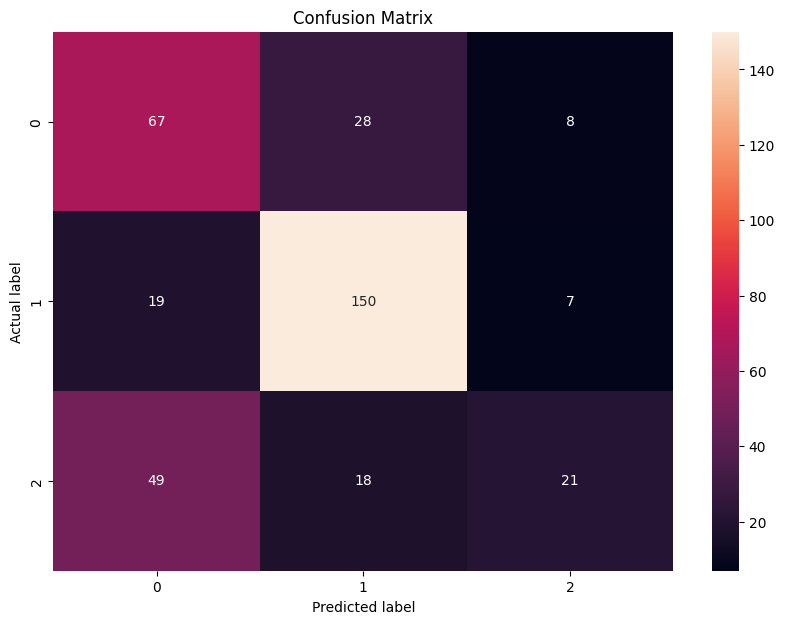

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
def predict_sentiment(text):
    inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids, attention_mask = inputs["input_ids"].to(device), inputs["attention_mask"].to(device)

    model_loaded.eval()
    with torch.no_grad():
        outputs = model_loaded(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).cpu().numpy()[0]

    return prediction

text = "aduhhhh guys ini pembayaran gua dibilang ineligible, padahal autodebet udah kepotong, gimanasih binus!"
prediction = predict_sentiment(text)
print(f'Predicted sentiment: {prediction}')

Predicted sentiment: 0


In [18]:
def predict_sentiment(text):
    inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids, attention_mask = inputs["input_ids"].to(device), inputs["attention_mask"].to(device)

    model_loaded.eval()
    with torch.no_grad():
        outputs = model_loaded(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).cpu().numpy()[0]

    return prediction

text = "Guys, kalo toilet cowo suka dikasih tissue apa emang kosong terus?"
prediction = predict_sentiment(text)
print(f'Predicted sentiment: {prediction}')

Predicted sentiment: 1


In [19]:
def predict_sentiment(text):
    inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids, attention_mask = inputs["input_ids"].to(device), inputs["attention_mask"].to(device)

    model_loaded.eval()
    with torch.no_grad():
        outputs = model_loaded(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).cpu().numpy()[0]

    return prediction

text = "Gilaa gua seneng banget ujian kali ini bisa gua kerjain"
prediction = predict_sentiment(text)
print(f'Predicted sentiment: {prediction}')

Predicted sentiment: 0


In [20]:
def predict_sentiment(text):
    inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids, attention_mask = inputs["input_ids"].to(device), inputs["attention_mask"].to(device)

    model_loaded.eval()
    with torch.no_grad():
        outputs = model_loaded(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).cpu().numpy()[0]

    return prediction

text = "halooo yang ketemu di kantin pake baju gucci tadi siang, lu ganteng bangeeett semoga di notis"
prediction = predict_sentiment(text)
print(f'Predicted sentiment: {prediction}')

Predicted sentiment: 2


In [36]:
def predict_sentiment(text):
    inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids, attention_mask = inputs["input_ids"].to(device), inputs["attention_mask"].to(device)

    model_loaded.eval()
    with torch.no_grad():
        outputs = model_loaded(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).cpu().numpy()[0]

    return prediction

text = input("Enter Text: ")
prediction = predict_sentiment(text)
print(f'Sentiment: {prediction}')

if prediction == 0:
  print("Prediction Sentiment: Negative")
elif prediction == 1:
  print("Prediction Sentiment: Neutral")
elif prediction == 2:
  print("Prediction Sentiment: Positive")

Enter Text: Binus! semangat ujiannya anak anak global class
Sentiment: 2
Prediction Sentiment: Positive
